In [1]:
# pip install tensorflow

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

2024-01-12 15:10:49.334105: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-12 15:10:49.361709: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 15:10:49.361732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 15:10:49.362420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 15:10:49.366431: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-12 15:10:49.366896: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
df = pd.read_csv("network_traffic.csv")

In [4]:
df['TotalBytes'] = df['BytesSent'] + df['BytesReceived']
df['TotalPackets'] = df['PacketsSent'] + df['PacketsReceived']

In [5]:
anomaly_data = df[df['IsAnomaly'] == 1]
oversampled_data = pd.concat([df, anomaly_data], axis=0)

In [6]:
X = oversampled_data.drop(columns=['IsAnomaly'])  # Features
Y = oversampled_data['IsAnomaly']  

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [9]:
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_forest.fit(X_train)

IsolationForest(contamination=0.1, random_state=42)

In [10]:
y_pred_iforest = isolation_forest.predict(X_test)
y_pred_iforest = (y_pred_iforest == -1) 

In [11]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification, use 'sigmoid' for anomaly detection
])

2024-01-12 15:10:55.376458: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

Epoch 1/5
21985/21985 [==============================] - 19s 863us/step - loss: 0.0579 - accuracy: 0.9898 - val_loss: 0.0565 - val_accuracy: 0.9900
Epoch 2/5
21985/21985 [==============================] - 19s 885us/step - loss: 0.0565 - accuracy: 0.9900 - val_loss: 0.0563 - val_accuracy: 0.9900
Epoch 3/5
21985/21985 [==============================] - 20s 887us/step - loss: 0.0563 - accuracy: 0.9900 - val_loss: 0.0562 - val_accuracy: 0.9900
Epoch 4/5
21985/21985 [==============================] - 20s 906us/step - loss: 0.0562 - accuracy: 0.9900 - val_loss: 0.0561 - val_accuracy: 0.9900
Epoch 5/5
4711/4711 [==============================] - 3s 548us/step


In [13]:
cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly'], zero_division=1)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

Text(0.5, 1.0, 'Confusion Matrix')

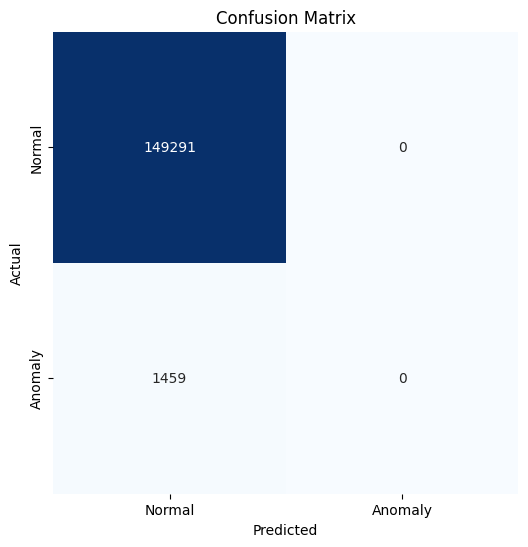

In [14]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')